## USE CASE - Download data from any dataset stored in CMEMS with active Opendap Service
<a target="_blank" href="https://colab.research.google.com/github/aragong/cmems_opendap/blob/main/cmems_opendap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

- Define initial data (dataset, cmems_user, and cmems_password)
- Load complete dataset indexes using pydap and xarray
- Subset required data (nearest data point to longitude and latitude [-6.58,36.88] and specific time range [year 1999])
- Plot example
- Export to netcdf
- Convert to pandas DataFrame
- Export to other formats from DataFrame (csv, json, html...)


Author: [German Aragon](https://ihcantabria.com/en/directorio-personal/investigador/german-aragon/) @ [IHCantabria](https://github.com/IHCantabria)

In [41]:
# Define dataset, username and password
dataset_id = "cmems_mod_ibi_wav_my_0.05deg-2D_PT1H-i"
username = "username" 
password = "password"

If you are using GOOGLE COLAB, uncoment **`!pip install pydap`** in the next cell before running.

In [42]:
# Uncomment line below if you are using Google Colab
# !pip install pydap
from pathlib import Path
import xarray as xr
from datetime import datetime
from matplotlib import pyplot as plt

In [43]:
# Function to access pydata stores from CMEMS modified by me
def _copernicusmarine_datastore(dataset, username, password):
    __author__ = "Copernicus Marine User Support Team"
    __copyright__ = "(C) 2021 E.U. Copernicus Marine Service Information"
    __credits__ = ["E.U. Copernicus Marine Service Information"]
    __license__ = "MIT License - You must cite this source"
    __version__ = "202104"
    __maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
    __email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"
    from pydap.cas.get_cookies import setup_session
    from pydap.client import open_url

    cas_url = "https://cmems-cas.cls.fr/cas/login"
    session = setup_session(cas_url, username, password)
    try:
        session.cookies.set("CASTGC", session.cookies.get_dict()["CASTGC"])
    except:
        raise ValueError(f"\033[1;31mUsername or/and password are incorrect!\033[0;0m\n")

    database = ["my", "nrt"]
    url = f"https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}"
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    except:
        url = f"https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}"
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    
    print(f"\033[1;32m'{username}' is successfully connected to '{dataset_id}'\033[0;0m\n")
    return data_store

def to_daily_netcdf(ds, output_path, netcdf_format=None):
    output_path = str(Path(output_path).resolve())
    output_dir = str(Path(output_path).parent)
    filename, file_ext = str(Path(output_path).stem), str(Path(output_path).suffix)
    
    date, datasets = zip(*ds.groupby("time.date"))
    paths = [f"{output_dir}/{filename}_{d}{file_ext}" for d in date]
    xr.save_mfdataset(datasets, paths, format=netcdf_format)
    return paths


In [44]:
# Connect to datastore
data_store = _copernicusmarine_datastore(dataset_id, username, password)
ds = xr.open_dataset(data_store)
ds

'garagon' is successfully connected to 'cmems_mod_ibi_wav_my_0.05deg-2D_PT1H-i'



<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 481, time: 245424)
Coordinates:
  * latitude   (latitude) float32 26.0 26.05 26.1 26.15 ... 55.9 55.95 56.0
  * longitude  (longitude) float32 -19.0 -18.95 -18.9 -18.85 ... 4.9 4.95 5.0
  * time       (time) datetime64[ns] 1993-01-01 ... 2020-12-30T23:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    ...         ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float32 ...
Attributes: (12/19)
    Conventions:    CF-1.0
    institution:    Nologin-Puertos del Estado-MeteoFrance
    title:          CMEMS IBI MULTI-YEAR REANALYSIS: HOURLY WAVE PRODUCTS
    easting:        longitude
    northing:       latitude
    references:     http://marine.copernicus.eu/
    ...             ...
    latitude_min:   26.f
    latitude_max:   56.f
    z_min:          0.0f
    z_max:          0.0f
    contact:        mailto: servicedesk.cmems@mercator-ocean.eu
    source:         IBI-MFC (Operational Production Center)

In [45]:
# Select 1 variable of the 17 available
subset_ds = ds.get("VHM0")

# You need to use dataset class to write in several netcdf files... I do not know if you can do it with datarray class.
subset_ds = subset_ds.to_dataset()

# Make spatial subset to nearest input point
subset_ds = subset_ds.sel(longitude=-6.58, latitude=36.88, method="nearest")
subset_ds

<xarray.Dataset>
Dimensions:    (time: 245424)
Coordinates:
    latitude   float32 36.9
    longitude  float32 -6.6
  * time       (time) datetime64[ns] 1993-01-01 ... 2020-12-30T23:00:00
Data variables:
    VHM0       (time) float32 ...

In [46]:
# Make temporal subset
subset_ds = subset_ds.sel(time=slice(datetime(1999,1,1), datetime(1999,2,1)))
subset_ds

<xarray.Dataset>
Dimensions:    (time: 745)
Coordinates:
    latitude   float32 36.9
    longitude  float32 -6.6
  * time       (time) datetime64[ns] 1999-01-01 ... 1999-02-01
Data variables:
    VHM0       (time) float32 ...

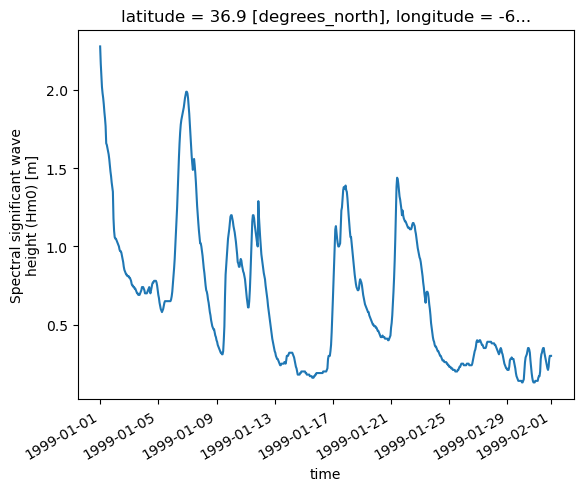

In [47]:
# Plot
subset_ds["VHM0"].plot()

In [48]:
# Write netcdf
subset_ds.to_netcdf("VHM0.nc")

# Write daily netcdf
paths = to_daily_netcdf(ds = subset_ds, output_path="VHM0.nc")

In [49]:
# Convert to Pandas DataFrame
df = subset_ds.to_dataframe()
df

,latitude,longitude,VHM0
time,,,
1999-01-01 00:00:00,36.900002,-6.6,2.28
1999-01-01 01:00:00,36.900002,-6.6,2.17
1999-01-01 02:00:00,36.900002,-6.6,2.09
1999-01-01 03:00:00,36.900002,-6.6,2.02
1999-01-01 04:00:00,36.900002,-6.6,1.98
...,...,...,...
1999-01-31 20:00:00,36.900002,-6.6,0.23
1999-01-31 21:00:00,36.900002,-6.6,0.28
1999-01-31 22:00:00,36.900002,-6.6,0.30


In [50]:
# Export to other formats... 
df.to_csv("VHM0.csv")
df.to_html("VHM0.html")

# Check arguments in libraries docuemntation for more options...
df.to_json("VHM0.json", orient="records", indent=4)